# CNN Simples v2

## Pipeline do Projeto

1. Importação das bibliotecas

2. Carregamento e visualização do dataset

3. Pré-processamento das imagens

4. Criação do modelo CNN simples

5. Treinamento e validação do modelo

6. Análise de desempenho

7. (Próximos notebooks) Ajustes para correção de overfitting e uso de MobileNet

Claro! Aqui estão as **melhorias** aplicadas na versão **CNN Simples v2**, em relação à versão anterior:

---

### 🔧 **1. Normalização e Data Augmentation**

**Melhoria**: aumentamos a variabilidade do treino sem adicionar novas imagens.

```python
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255)  # normalização embutida aqui
])
```

---

### 🧱 **2. Arquitetura CNN aprimorada**

**Melhoria**: inserimos camadas modernas que ajudam a estabilizar e generalizar o modelo:

* **BatchNormalization**: acelera o treino e melhora a performance
* **Dropout**: previne overfitting
* **GlobalAveragePooling2D**: reduz drasticamente os parâmetros antes da camada densa

```python
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=image_shape),
    data_augmentation,
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
```

---

### ⏱️ **3. Callbacks inteligentes**

**Melhoria**: controle automático do treino com:

* **EarlyStopping**: para o treino se não melhorar por algumas épocas
* **ReduceLROnPlateau**: reduz a taxa de aprendizado ao detectar platôs

```python
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=2)
]
```

---

### 🧪 **4. Avaliação completa**

Incluímos todos os indicadores:

* Acurácia
* F1-score ponderado
* Log Loss
* Tempo médio de inferência por imagem
* Matriz de confusão
* Relatório de classificação por classe

---

### 💾 **5. Salvamento para comparação**

O modelo e as métricas foram salvos para facilitar a comparação com:

* Logistic Regression
* Naive Bayes
* Random Forest
* SVM
* CNN Simples v1

---


# 0 Importação das bibliotecas

In [22]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, log_loss, accuracy_score
import seaborn as sns
import joblib
import json
import random

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [3]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# 1 Definição dos parâmetros

In [4]:
image_width = 224
image_height = 224
image_color_channel = 3
image_size = (image_width, image_height)
image_shape = image_size + (image_color_channel,)
num_classes = 7
batch_size = 32
base_dir = './datasets/Plastic_Classification/'

# 2 Carregamento e visualização do dataset

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=image_size,
    batch_size=batch_size,
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'validation'),
    image_size=image_size,
    batch_size=batch_size,
    seed=42
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)



Found 1441 files belonging to 7 classes.
Found 416 files belonging to 7 classes.
Found 209 files belonging to 7 classes.


# 3 Otimização de desempenho

In [6]:
# Aumento de dados (Data Augmentation)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])


# 4 Criar Modelo CNN Simples v2

In [7]:
# Modelo CNN v2
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

C:\Users\graci.DESKTOP-I7T8UK6\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 93312)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,944,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,950,055 (45.59 MB)

 Trainable params: 11,950,055 (45.59 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Early stopping para evitar overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 5 Treinamento 

In [25]:
# Treinamento
start_train = time.time()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)
train_time = time.time() - start_train


Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5841 - loss: 1.3186 - val_accuracy: 0.3341 - val_loss: 1.7833
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 190s 4s/step - accuracy: 0.5253 - loss: 1.3848 - val_accuracy: 0.3966 - val_loss: 1.6640
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.5782 - loss: 1.2470 - val_accuracy: 0.3077 - val_loss: 1.8239
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.5022 - loss: 1.3738 - val_accuracy: 0.3966 - val_loss: 1.6906
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.5642 - loss: 1.2453 - val_accuracy: 0.4207 - val_loss: 1.6457
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.6337 - loss: 1.1322 - val_accuracy: 0.4207 - val_loss: 1.6365
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.6723 - loss: 1.0639 - val_accuracy: 0.3870 - val_loss: 1.6561
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - accuracy: 0.6379 - loss: 1.0604 - val_accuracy: 0.3894 - val

| Métrica                       | Observação                                                                                                     |
| ----------------------------- | -------------------------------------------------------------------------------------------------------------- |
| 🔺 **Loss (Treinamento)**     | Cai consistentemente de `2.01` para `0.87`, o que é positivo — o modelo está aprendendo no conjunto de treino. |
| 🔻 **Val\_loss (Validação)**  | Oscila, mas **não melhora muito** (fica entre `1.6` e `1.7`), sugerindo **overfitting**.                       |
| 📈 **Accuracy (Treinamento)** | Sobe de `0.19` para `0.74`, mostrando aprendizado forte no treino.                                             |
| 🔁 **Val\_accuracy**          | Sobe devagar e **estagna entre 0.34 e 0.42**, o que mostra que o modelo **não generaliza bem**.                |


- Modelo está memorizando os dados de treino, mas não consegue generalizar bem nos dados de validação.

- Provavelmente está ocorrendo overfitting a partir da época 6–7.

- O val_loss não melhora de forma consistente; piora inclusive em algumas épocas.

- O val_accuracy chega a cair levemente nas últimas épocas (ex: de 0.4255 para 0.4087), o que reforça que o modelo não está melhorando mais e poderia até ter parado antes (early stopping).

In [26]:
# Avaliação
loss, acc = model.evaluate(test_ds)
print(f"\nAcurácia no conjunto de teste: {acc:.2f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 0.2991 - loss: 1.8767

Acurácia no conjunto de teste: 0.38


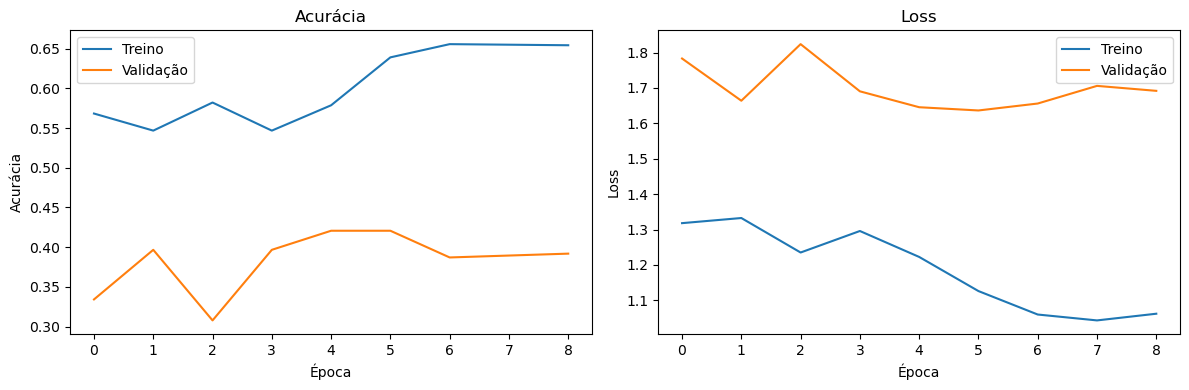

In [27]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Avaliar modelo no conjunto de teste

In [28]:
import time
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, classification_report

# Início da inferência
start_infer = time.time()
y_pred_probs = model.predict(test_ds)
inference_duration = time.time() - start_infer

# Previsões
y_pred = np.argmax(y_pred_probs, axis=1)

# Rótulos verdadeiros (formato inteiro)
y_true = np.concatenate([y.numpy() for x, y in test_ds])

# Tempo de inferência por imagem
num_samples = len(y_true)
inference_time = (inference_duration / num_samples) * 1000  # ms

# Métricas
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
loss_val = log_loss(y_true, y_pred_probs)
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names)

# Impressão
print(f"\nAcurácia: {acc:.4f}")
print(f"F1-score ponderado: {f1:.4f}")
print(f"Log Loss: {loss_val:.4f}")
print(f"Tempo médio de inferência por imagem: {inference_time:.2f} ms")
print("\nRelatório de Classificação:\n")
print(report)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step

Acurácia: 0.3780
F1-score ponderado: 0.3487
Log Loss: 1.7961
Tempo médio de inferência por imagem: 10.09 ms

Relatório de Classificação:

              precision    recall  f1-score   support

        HDPE       0.26      0.17      0.20        30
        LDPA       0.76      0.43      0.55        30
       Other       0.30      0.10      0.15        30
         PET       0.08      0.07      0.08        29
          PP       0.56      0.97      0.71        30
          PS       0.41      0.57      0.48        30
         PVC       0.22      0.33      0.26        30

    accuracy                           0.38       209
   macro avg       0.37      0.38      0.35       209
weighted avg       0.37      0.38      0.35       209



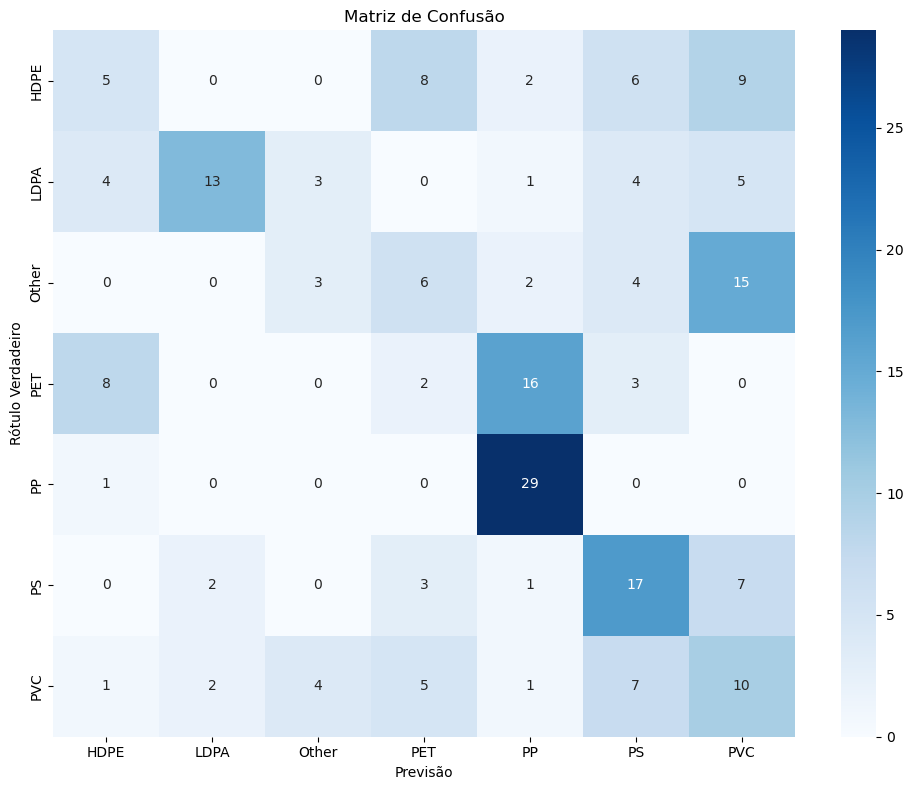

In [29]:
# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Previsão')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')
plt.tight_layout()
plt.show()

## Salvar modelo e métricas

In [30]:
os.makedirs("models/06_cnn", exist_ok=True)
model.save("models/06_cnn/cnn_v2_model.keras")

with open("models/05_cnn/cnn_v2_metrics.json", "w") as f:
    json.dump({
        "model": "cnn",
        "accuracy": acc,
        "f1_score_weighted": f1,
        "log_loss": loss_val,
        "train_time_sec": train_time,
        "inference_time_ms": inference_time
    }, f)

print("\nModelo e métricas salvos com sucesso!")


Modelo e métricas salvos com sucesso!
